# Import Module

In [2]:
import h5py
import numpy as np
from sklearn.utils import shuffle
from tqdm import tqdm
import os
import cv2
import keras
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing import image
from keras.preprocessing.image import *
from keras.applications.inception_v3 import *
import random
np.random.seed(2017)
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
%matplotlib inline

# Visual Module

In [6]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        # loss
        plt.figure(1)
        ylim(0.009,0.02)
        plt.title('loss')
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        plt.grid(True)
        plt.legend(loc="upper right")
        # acc
        plt.figure(2)
        ylim(0.99, 1)
        plt.title('acc')
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        plt.grid(True)
        
        if loss_type == 'epoch':
            # val_loss
            plt.figure(1)
            ylim(0.009,0.02)
            plt.title('val_loss')
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
            plt.legend(loc="upper right")
            # val_acc
            plt.figure(2)
            ylim(0.99, 1)
            plt.title('val_acc')
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
        plt.legend(loc="upper right")
        plt.show()

# Read Data

In [3]:
X_train=[]
X_test=[]
for fn in ["gap_ResNet50.h5",
           "gap_InceptionV3.h5",
            "gap_InceptionResNetV2.h5",
            "gap_Xception.h5"]:
    with h5py.File(fn, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        Y_train=np.array(h['label'])
X_train=np.concatenate(X_train, axis=1)
X_test=np.concatenate(X_test, axis=1)
X_train,Y_train=shuffle(X_train, Y_train)

# Create a model and compile

In [30]:
input_tensor = Input(X_train.shape[1:])
x = input_tensor
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(input_tensor, x)

model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

[('input_1', 0), ('dropout_1', 1), ('dense_1', 2)]


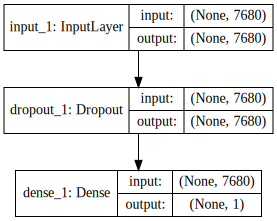

In [7]:
from IPython.display import SVG, Image
from keras.utils.vis_utils import model_to_dot, plot_model

plot_model(model, show_shapes=True, to_file='model.png')

print([(x,y)for (x,y) in zip([x.name for x in model.layers], range(len(model.layers)))])

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

# Training model

In [31]:
history = LossHistory()
model.fit(X_train, Y_train, batch_size=256, nb_epoch=6, validation_split=0.2,callbacks=[history])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 19971 samples, validate on 4993 samples
Epoch 1/6
19971/19971 [==============================] - 1s 52us/step - loss: 0.0598 - acc: 0.9806 - val_loss: 0.0164 - val_acc: 0.9950
Epoch 2/6
19971/19971 [==============================] - 1s 39us/step - loss: 0.0166 - acc: 0.9949 - val_loss: 0.0126 - val_acc: 0.9960
Epoch 3/6
19971/19971 [==============================] - 1s 39us/step - loss: 0.0146 - acc: 0.9954 - val_loss: 0.0122 - val_acc: 0.9966
Epoch 4/6
19971/19971 [==============================] - 1s 39us/step - loss: 0.0122 - acc: 0.9965 - val_loss: 0.0113 - val_acc: 0.9968
Epoch 5/6
19971/19971 [==============================] - 1s 39us/step - loss: 0.0114 - acc: 0.9964 - val_loss: 0.0114 - val_acc: 0.9970
Epoch 6/6
19971/19971 [==============================] - 1s 39us/step - loss: 0.0096 - acc: 0.9975 - val_loss: 0.0110 - val_acc: 0.9966


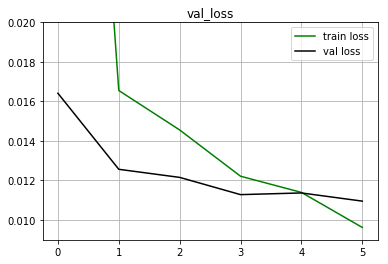

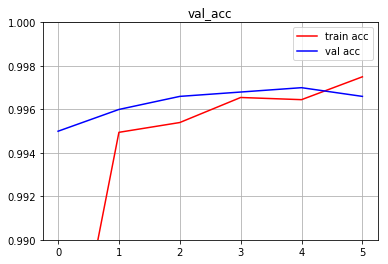

In [32]:
history.loss_plot('epoch')

# Save and load models

In [140]:
model.save('model-mix-4-adam-256.h5')

In [65]:
model=load_model('model-mix-4-adam-256.h5')

# Test model

In [33]:
y_pred = model.predict(X_test, verbose=1)

12500/12500 [==============================] - 1s 49us/step


# Visual prediction results

Found 12500 images belonging to 1 classes.


100%|██████████| 20/20 [00:08<00:00,  2.44it/s]


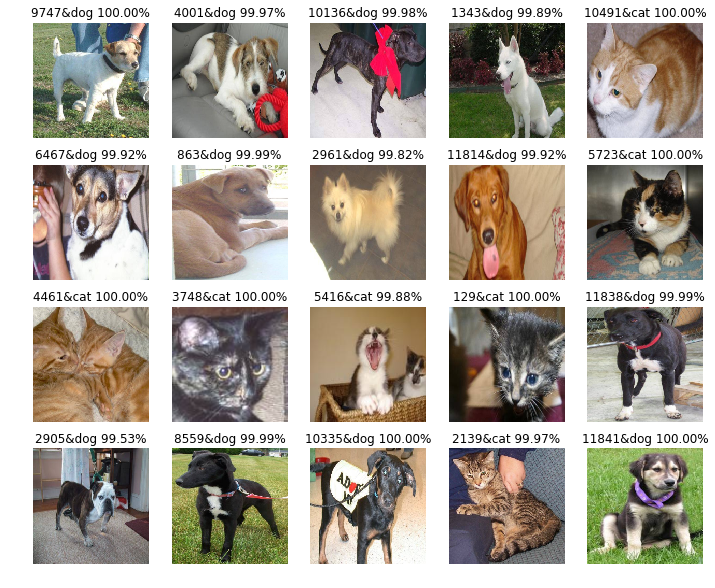

In [144]:
idg = ImageDataGenerator()
test_generator = idg.flow_from_directory("dtest", (299,299), shuffle=False, 
                                       batch_size=16, class_mode=None)
index=test_generator.filenames
num=len(index)

plt.figure(figsize=(12, 10))
for i in tqdm(range(20)):
    k=random.randint(1,num)
    prediction=y_pred[k-1]

    fname=index[k-1]
    ind= int(fname[fname.rfind('/')+1:fname.rfind('.')])
    img = cv2.imread(fname)
    img = cv2.resize(img,(224,224))
    plt.subplot(4, 5, i+1)
    if prediction < 0.5:
        plt.title(str(ind)+'&cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title(str(ind)+'&dog %.2f%%' % (prediction*100))
    
    plt.axis('off')
    plt.imshow(img[:,:,::-1]) # convert BGR to RGB

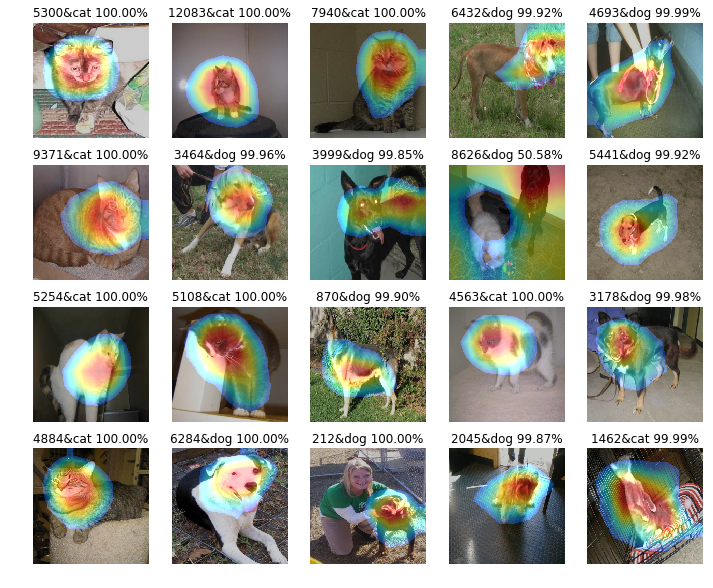

In [145]:
weights = model.layers[2].get_weights()[0][2048:4096]

base_model = InceptionV3(weights='imagenet', include_top=False)  

plt.figure(figsize=(12, 10))
test_cam=[]
for i in range(20):
    
    k=random.randint(1,num)
    prediction=y_pred[k-1][0]    
    
    fname=index[k-1]
    ind= int(fname[fname.rfind('/')+1:fname.rfind('.')])

    img_path='dtest/'+fname
    img = image.load_img(img_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x =preprocess_input(x)
    test_cam=base_model.predict(x)
    base_model_outputs=test_cam[0]
    
    plt.subplot(4, 5, i+1)
    if prediction < 0.5:
        plt.title(str(ind)+'&cat %.2f%%' % (100 - prediction*100))
    else:
        plt.title(str(ind)+'&dog %.2f%%' % (prediction*100))
    
    cam = (prediction - 0.5) * np.matmul(base_model_outputs, weights)
    cam -= cam.min()
    cam /= cam.max()
    cam -= 0.2
    cam /= 0.8    
    cam = cv2.resize(cam, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.2)] = 0
    
    imgn = cv2.imread(img_path)
    imgn = cv2.resize(imgn,(224,224))
    out = cv2.addWeighted(imgn, 0.8, heatmap, 0.4, 0)
    
    plt.axis('off')
    plt.imshow(out[:,:,::-1])

# Generate a form

In [34]:
y_clip = y_pred.clip(min=0.005, max=0.995)
import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

idg = ImageDataGenerator()
test_generator = idg.flow_from_directory("dtest", (224, 224), shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_clip[i])

df.to_csv('my-sub-mix-4-adam-256.csv', index=None)
df.head(10)

Found 12500 images belonging to 1 classes.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  del sys.path[0]


,id,label
0,1,0.995
1,2,0.995
2,3,0.995
3,4,0.995
4,5,0.005
5,6,0.005
6,7,0.005
7,8,0.005
8,9,0.005
9,10,0.005
